In [1]:
import jax

from jax import lax, random, numpy as jnp


import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training.train_state import TrainState


import optax
import pprint
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import functools
from typing import Any, Callable, Sequence, Optional

import numpy as np
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(indent=4)

In [2]:
model = nn.Dense(features=5)

In [3]:
## Step 1: init

seed = 23
key1, key2 = random.split(random.PRNGKey(seed))

x = random.normal(key1, (10, ))

y, params = model.init_with_output(key2, x)

print(y)
print(jax.tree_map(lambda x: x.shape, params))

[-1.2137767  -0.3663314   0.06677872 -2.0143979  -0.32107335]
{'params': {'bias': (5,), 'kernel': (10, 5)}}


In [4]:
## Step 2: apply

y = model.apply(params, x) # this is how you run prediction in Flax, state is external!
print(y)

[-1.2137767  -0.3663314   0.06677872 -2.0143979  -0.32107335]


In [5]:
n_samples = 1500
x_dim = 2
y_dim  = 1
noise_amplitude = 0.1

key, w_key, b_key = random.split(random.PRNGKey(seed), num=3)

W = random.normal(w_key, (x_dim, y_dim)) # weight
b = random.normal(b_key, (y_dim, )) # bias

true_params = freeze({'params': {'bias': b, 'kernel': W}})

# Generate samples with additional noise

key, x_key, noise_key = random.split(key, num=3)
xs = random.normal(x_key, (n_samples, x_dim))
ys = jnp.dot(xs, W) + b
ys += noise_amplitude * random.normal(noise_key, (n_samples, y_dim))

print(f"xs shape = {xs.shape}, ys shape = {ys.shape}")

xs shape = (1500, 2), ys shape = (1500, 1)


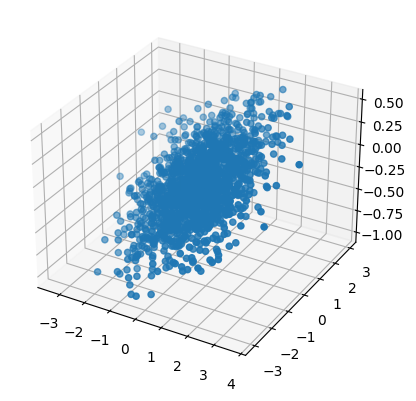

In [6]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
assert xs.shape[-1] == 2 and ys.shape[-1] == 1
ax.scatter(xs[:, 0], xs[:, 1], zs=ys)

# y = w*x +b -> w1*x1 + w2*x2 + b -> 2D plane in 3D space
plt.show()

In [7]:
def make_mse_loss(xs, ys):

  def mse_loss(params):
    """
      Gives the value of the loss on the (xs, ys)
      dataset for the given model (params)
    """

    # Define the squared loss for a single pair (x, y)
    def squared_error(x, y):
      pred = model.apply(params, x)
      # Inner because `y` could have in general more than 1 dims
      return jnp.inner(y-pred, y-pred) / 2.0

    # Batched version via vmap
    return jnp.mean(jax.vmap(squared_error)(xs, ys), axis=0)

  return jax.jit(mse_loss) # and finally we jit the result (mse_loss is a pure function)


mse_loss = make_mse_loss(xs, ys)
value_and_grad_fn = jax.value_and_grad(mse_loss)

In [8]:
model = nn.Dense(features=y_dim)
params = model.init(key, xs)
print(f"Initial params = {params}")

# Let's set some reasonable hyperparams
lr = 0.3
epochs = 20
log_period_epoch = 5

print('-' * 50)

for epoch in range(epochs):
  loss, grads = value_and_grad_fn(params)

  # BGD (closer to jax again)
  params = jax.tree_map(lambda p, g: p - lr * g, params, grads)

  if epoch % log_period_epoch == 0:
    print(f"Epoch {epoch}, loss = {loss}")

print("-" * 50)
print(f"Learned params = {params}")
print(f"Gt params = {true_params}")

Initial params = {'params': {'kernel': Array([[1.1737938 ],
       [0.41188157]], dtype=float32), 'bias': Array([0.], dtype=float32)}}
--------------------------------------------------
Epoch 0, loss = 0.6885039806365967
Epoch 5, loss = 0.020000528544187546
Epoch 10, loss = 0.005448050331324339
Epoch 15, loss = 0.0051234569400548935
--------------------------------------------------
Learned params = {'params': {'bias': Array([-0.2549984], dtype=float32), 'kernel': Array([[0.08552127],
       [0.21779607]], dtype=float32)}}
Gt params = FrozenDict({
    params: {
        bias: Array([-0.25356248], dtype=float32),
        kernel: Array([[0.08546512],
               [0.22107157]], dtype=float32),
    },
})


In [9]:
opt_sgd = optax.sgd(learning_rate=lr)
opt_state = opt_sgd.init(params) # always the same pattern - handling state externally
print(opt_state)

(EmptyState(), EmptyState())


In [10]:
params = model.init(key, xs)

for epoch in range(epochs):
  loss, grads = value_and_grad_fn(params)
  updates, opt_state = opt_sgd.update(grads, opt_state) # arbirary optim logic!

  params = optax.apply_updates(params, updates)

  if epoch % log_period_epoch == 0:
      print(f"Epoch {epoch}, loss = {loss}")

Epoch 0, loss = 0.6885039806365967
Epoch 5, loss = 0.020000528544187546
Epoch 10, loss = 0.005448050331324339
Epoch 15, loss = 0.0051234569400548935


In [11]:
class MLP(nn.Module):
  num_neurons_per_layer : Sequence[int] # data field (nn.Module is Python's dataclass)

  # def setup(self):
  #   self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]

  @nn.compact
  def __call__(self, x):
    activation = x
    for i, num_neurons in enumerate(self.num_neurons_per_layer):
      activation = nn.Dense(num_neurons)(activation)
      if i != len(self.num_neurons_per_layer) - 1:
        activation == nn.relu(activation)

    return activation


x_key, init_key = random.split(random.PRNGKey(seed))

model = MLP(num_neurons_per_layer=[16, 8, 1]) # define a MLP model
x = random.uniform(x_key, (4, 4))
params = model.init(init_key, x) # initialize via init
y = model.apply(params, x) # do a forward pass via apply

pp.pprint(jax.tree_map(jnp.shape, params))
print(f"Output: {y}")

{   'params': {   'Dense_0': {'bias': (16,), 'kernel': (4, 16)},
                  'Dense_1': {'bias': (8,), 'kernel': (16, 8)},
                  'Dense_2': {'bias': (1,), 'kernel': (8, 1)}}}
Output: [[-0.13382667]
 [ 0.12416806]
 [-0.24299379]
 [-0.5010956 ]]


In [12]:
class MyDenseImp(nn.Module):
  num_neurons: int
  weight_init: Callable = nn.initializers.lecun_normal()
  bias_init: Callable = nn.initializers.zeros

  @nn.compact
  def __call__(self, x):
    weight = self.param('weight', # parameter name (as it will appear in the FrozenDict)
                        self.weight_init, # initialization function, RNG passed implicitly through init fn
                        (x.shape[-1], self.num_neurons)) # shape info
    bias = self.param('bias', self.bias_init, (self.num_neurons,))

    return jnp.dot(x, weight) + bias


x_key, init_key = random.split(random.PRNGKey(seed))

model = MyDenseImp(num_neurons=3)
x = random.uniform(x_key, (4, 4))
params = model.init(init_key, x)
y = model.apply(params, x)

pp.pprint(jax.tree_map(jnp.shape, params))
print(f"Output: {y}")

{'params': {'bias': (3,), 'weight': (4, 3)}}
Output: [[-0.4543119   0.14070597 -0.1399677 ]
 [-0.32604304 -0.02913585  0.21127704]
 [-0.16531758  0.2607744  -0.37982285]
 [-0.01778072  0.40737242 -0.1099543 ]]


### Variable

ML models often times have variables which are part of the state but are not optimized via gradient descent.

In [13]:
class BiasAdderWithRunningMean(nn.Module):
  decay: float = 0.99

  @nn.compact
  def __call__(self, x):
    is_initialized = self.has_variable('batch_stats', 'ema')

    # Flax uses that name in its implementation of BatchNorm (hard-coded, probably not the best way)
    ema = self.variable('batch_stats', 'ema', lambda shape: jnp.zeros(shape), x.shape[1:])

    # self.param will be defaul add this variable to 'params' collection (vs 'batch_state above)
    # Again some idosyncrasies here we need to pass a key even though we don't actually use it...
    bias = self.param('bias', lambda key, shape: jnp.zeros(shape), x.shape[1:])


    if is_initialized:
      # self.variable return a reference hence value
      ema.value = self.decay * ema.value + (1.0 - self.decay) * np.mean(x, axis=0, keepdims=True)


    return x - ema.value + bias

x_key, init_key = random.split(random.PRNGKey(seed))

model = BiasAdderWithRunningMean()
x = random.uniform(x_key, (10, 4))
variables = model.init(init_key, x)

pp.pprint(f"Multiple collections = {variables}")

# We have to use mutable since regular params are not modified during the forward
# pass, but these variables are. We can't keep state internally (because JAX) so we have to return it.
y, updated_non_trainable_params = model.apply(variables, x, mutable=['batch_stats'])

print(updated_non_trainable_params)

("Multiple collections = {'batch_stats': {'ema': Array([0., 0., 0., 0.], "
 "dtype=float32)}, 'params': {'bias': Array([0., 0., 0., 0.], dtype=float32)}}")
{'batch_stats': {'ema': Array([[0.00421787, 0.00597094, 0.00638907, 0.00699901]], dtype=float32)}}


In [14]:
def update_step(opt, apply_fn, opt_state, x, params, non_trainable_params):

  def loss_fn(params):
    y, updated_non_trainable_params = apply_fn(
        {'params': params, **non_trainable_params},
        x, mutable=list(non_trainable_params.keys())
    )

    loss = ((x - y)**2).sum()

    return loss, updated_non_trainable_params

  (loss, non_trainable_params), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = opt.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state, params, non_trainable_params # all of these represent the state


model = BiasAdderWithRunningMean()
x = jnp.ones((10, 4))

variables = model.init(random.PRNGKey(seed), x)
params = variables.pop('params')
non_trainable_params = variables
del variables

sgd_opt = optax.sgd(learning_rate=0.1)
opt_state = sgd_opt.init(params)

for _ in range(3):
  opt_state, params, non_trainable_params = update_step(sgd_opt, model.apply, opt_state, x, params, non_trainable_params)
  pp.pprint(non_trainable_params)

{'batch_stats': {'ema': Array([[0.01, 0.01, 0.01, 0.01]], dtype=float32)}}
{   'batch_stats': {   'ema': Array([[0.0199, 0.0199, 0.0199, 0.0199]], dtype=float32)}}
{   'batch_stats': {   'ema': Array([[0.029701, 0.029701, 0.029701, 0.029701]], dtype=float32)}}


In [15]:
class DDNBlock(nn.Module):
  """Dense, drop + batchnorm combo.

  Contains trainable variables (params), non-trainable variables (batch stats),
  and stochasticity in the foward pass (because of dropout).
  """

  num_neurons: int
  training: bool

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(self.num_neurons)(x)
    x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
    x = nn.BatchNorm(use_running_average=not self.training)(x)
    return x

key1, key2, key3, key4 = random.split(random.PRNGKey(seed), 4)

model = DDNBlock(num_neurons=3, training=True)
x = random.uniform(key1, (3, 4, 4))

variables = model.init({'params': key2, 'dropout': key3}, x)
print(variables)

y, non_trainable_params = model.apply(variables, x, rngs={'dropout': key4}, mutable=['batch_stats'])

eval_model = DDNBlock(num_neurons=3, training=False)

y = eval_model.apply(variables, x)



{'params': {'Dense_0': {'kernel': Array([[-0.7563737 ,  0.01997766,  0.04605455],
       [ 0.65764475, -0.7379195 , -0.3011639 ],
       [ 0.80684876,  0.7780826 ,  0.09813767],
       [ 0.1541389 ,  0.17243949,  0.44406676]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}, 'BatchNorm_0': {'scale': Array([1., 1., 1.], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}}, 'batch_stats': {'BatchNorm_0': {'mean': Array([0., 0., 0.], dtype=float32), 'var': Array([1., 1., 1.], dtype=float32)}}}


In [16]:
class CNN(nn.Module):  # lots of hardcoding, but it serves a purpose for a simple demo
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    return x

In [17]:
def custom_transform(x):
    return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

mnist_img_size = (28, 28, 1)
batch_size = 128

train_dataset = MNIST(root='train_mnist',
                      train=True,
                      download=True,
                      transform=custom_transform)
test_dataset = MNIST(root='test_mnist',
                     train=False,
                     download=True,
                     transform=custom_transform)

train_loader = DataLoader(train_dataset,
                          batch_size,
                          collate_fn=custom_collate_fn,
                          shuffle=True,
                          drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size,
                         collate_fn=custom_collate_fn,
                         shuffle=False,
                         drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data)
train_lbls = jnp.array(train_dataset.targets)

# np.expand_dims is to convert shape from (10000, 28, 28) -> (10000, 28, 28, 1)
# We don't have to do this for training images because custom_transform does it for us.
test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_lbls = jnp.array(test_dataset.targets)

100%|██████████| 9912422/9912422 [00:00<00:00, 127406231.98it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 7454045.52it/s]


Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38328565.63it/s]


Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12243270.42it/s]


Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 141300558.89it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29814347.48it/s]


Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43000182.78it/s]


Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5312473.16it/s]


Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(128, 28, 28, 1) float32 (128,) int64


Ground Truth Label: 5


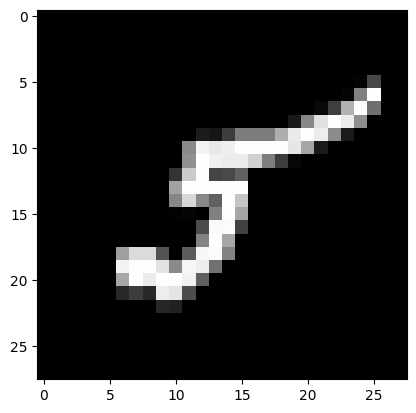

In [18]:
img = imgs[0].reshape(mnist_img_size)[:, :, 0]
gt_lbl = lbls[0]

print(f"Ground Truth Label: {gt_lbl}")
plt.imshow(img, cmap='gray')
plt.show()

In [19]:
@jax.jit
def train_step(state, imgs, gt_labels):
  def loss_fn(params):
    logits = CNN().apply({'params': params}, imgs)
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)
    loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
    return loss, logits

  (_, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, gt_labels=gt_labels)
  return state, metrics


@jax.jit
def eval_step(state, imgs, gt_labels):
  logits = CNN().apply({'params': state.params}, imgs)
  return compute_metrics(logits=logits, gt_labels=gt_labels)


In [20]:
def train_one_epoch(state, dataloader, epoch):
  """Train for 1 epoch on the training set."""
  batch_metrics = []
  for cnt, (imgs, labels) in enumerate(dataloader):
    state, metrics = train_step(state, imgs, labels)
    batch_metrics.append(metrics)

  # Aggregate the metrics
  batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]
  }

  return state, epoch_metrics_np

def evaluate_model(state, test_imgs, test_lbls):
  """Evaluate on the validation set."""

  metrics = eval_step(state, test_imgs, test_lbls)
  metrics = jax.device_get(metrics)
  metrics = jax.tree_map(lambda x: x.item(), metrics) # nd.ndarray -> scalar

  return metrics

In [21]:
def create_train_state(key, learning_rate, momentum):
  cnn = CNN()
  params = cnn.init(key, jnp.ones([1, *mnist_img_size]))['params']
  sgd_opt = optax.sgd(learning_rate, momentum)

  return TrainState.create(apply_fn=cnn.apply, params=params, tx=sgd_opt)


def compute_metrics(*, logits, gt_labels):
  one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)

  loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == gt_labels)

  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [22]:
seed = 0
learning_rate = 0.1
momentum = 0.9
num_epochs = 2
batch_size = 32

train_state = create_train_state(jax.random.PRNGKey(seed), learning_rate, momentum)

for epoch in range(1, num_epochs + 1):
  train_state, train_metrics = train_one_epoch(train_state, train_loader, epoch)
  print(f"Trian epoch: {epoch}, loss: {train_metrics['loss']}, accuracy: {train_metrics['accuracy']}")

  test_metrics = evaluate_model(train_state, test_images, test_lbls)
  print(f"Test epoch: {epoch}, loss: {test_metrics['loss']}, accuracy: {test_metrics['accuracy']}")

Trian epoch: 1, loss: 0.207587331533432, accuracy: 0.9371995329856873
Test epoch: 1, loss: 10.071449279785156, accuracy: 0.9817999601364136
Trian epoch: 2, loss: 0.048635344952344894, accuracy: 0.9853932857513428
Test epoch: 2, loss: 8.860603332519531, accuracy: 0.9850999712944031
